# Regressão Linear
## APRAU - Grupo 3

Este notebook implementa modelos de **Regressão Linear** para prever `target_regression` usando o método **hold-out (80/20)**.

**Objetivos:**
1. **Simple Linear Regression**: Identificar a feature com maior poder preditivo individual
2. **Multiple Linear Regression**: Combinar múltiplas features para maximizar performance preditiva
3. **Comparação**: Avaliar trade-off entre simplicidade e performance usando R², MAE e RMSE

In [3]:
# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats

# Configuração visual dos gráficos
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

## Preparação dos Dados

Carregamos o dataset e aplicamos as transformações identificadas na análise exploratória:
- Conversão de `focus_factor` (formato numérico)
- Consolidação de features `duration_*` numa única variável
- Remoção de features problemáticas (constantes, redundantes, alvos alternativos)

**Método de Validação**: Hold-out 80/20 (2400 treino, 600 teste) com `random_state=42` para reprodutibilidade.

In [4]:
df = pd.read_csv('../Data/group_3.csv')

# Corrigir focus_factor: converter vírgulas em pontos e transformar em float
if df['focus_factor'].dtype == 'object':
    df['focus_factor'] = df['focus_factor'].str.replace(',', '.').astype(float)

# Consolidar duration: combinar duration_1 até duration_5 numa única variável
duration_cols = ['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5']
if all(c in df.columns for c in duration_cols):
    df['duration'] = df[duration_cols].values @ np.arange(1, 6)  # Produto matricial para agregar
    df = df.drop(columns=duration_cols)

# Remover features problemáticas identificadas na análise exploratória
drop = ['echo_constant','is_dance_hit','temp_zscore','signal_power','duration_log','target_class']
df = df.drop(columns=drop)

# Separar features (X) e target (y)
X = df.drop('target_regression', axis=1)
y = df['target_regression']

# Hold-out split: 80% treino, 20% teste, random_state fixo para reprodutibilidade
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"{len(X)} obs, {len(X.columns)} features | Train: {len(X_train)}, Test: {len(X_test)}")

3000 obs, 38 features | Train: 2400, Test: 600


## 1. Simple Linear Regression

Testamos **cada feature individualmente** para identificar qual possui o maior poder preditivo isolado. Esta abordagem permite:
- Quantificar a contribuição individual de cada variável
- Validar as correlações identificadas na análise exploratória
- Estabelecer um baseline de performance

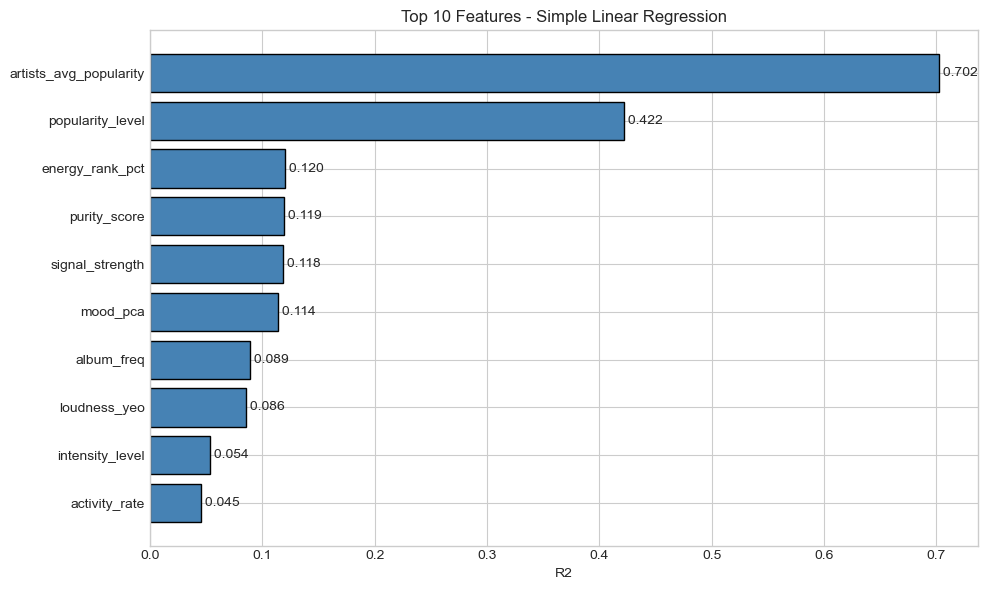

,Feature,R2,MAE,RMSE
16,artists_avg_popularity,0.701983,0.255300,0.425603
1,popularity_level,0.421613,0.408557,0.592917
18,energy_rank_pct,0.120217,0.622368,0.731260
10,purity_score,0.119118,0.615960,0.731717
24,signal_strength,0.118140,0.618858,0.732123
20,mood_pca,0.114034,0.622194,0.733825
6,album_freq,0.089282,0.661070,0.744005
32,loudness_yeo,0.085660,0.625195,0.745483
8,intensity_level,0.053710,0.640813,0.758396
12,activity_rate,0.045480,0.659909,0.761687


In [5]:
# Testar cada feature individualmente com Simple Linear Regression
results = []
for col in X.columns:
    # Treinar modelo com apenas uma feature
    lr = LinearRegression().fit(X_train[[col]], y_train)
    pred = lr.predict(X_test[[col]])

    # Calcular métricas de performance
    results.append({'Feature': col, 'R2': r2_score(y_test, pred),
                   'MAE': mean_absolute_error(y_test, pred),
                   'RMSE': np.sqrt(mean_squared_error(y_test, pred))})

# Ordenar features por R2 decrescente (melhor para pior)
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)

# Visualizar top 10 features
fig, ax = plt.subplots(figsize=(10, 6))
top10 = results_df.head(10)
ax.barh(range(len(top10)), top10['R2'], color='steelblue', edgecolor='black')
ax.set_yticks(range(len(top10)))
ax.set_yticklabels(top10['Feature'])
ax.set_xlabel('R2')
ax.set_title('Top 10 Features - Simple Linear Regression')
ax.invert_yaxis()  # Melhor feature no topo
for i, v in enumerate(top10['R2']):
    ax.text(v, i, f' {v:.3f}', va='center')
plt.tight_layout()
plt.show()

results_df

### Resultados - Ranking de Features

**Destaque absoluto**: `artists_avg_popularity` com **R² = 0.702** explica sozinha **70.2% da variância** da target, confirmando ser a variável dominante identificada na análise exploratória (correlação r=0.847).

**Top 3 Features**:
1. **artists_avg_popularity** (R²=0.702): Popularidade média dos artistas
2. **popularity_level** (R²=0.422): Nível de popularidade da música
3. **energy_rank_pct** (R²=0.120): Percentil de energia

**Observação crítica**: Existe um **gap enorme** entre a 1ª feature (70.2%) e a 2ª (42.2%), indicando que `artists_avg_popularity` captura informação única e altamente preditiva. As features seguintes apresentam R² < 0.15, sugerindo redundância ou baixo poder preditivo isolado.

In [6]:
# Treinar modelo final com a melhor feature
best = results_df.iloc[0]['Feature']  # Feature com maior R2
lr_simple = LinearRegression().fit(X_train[[best]], y_train)
y_pred_s = lr_simple.predict(X_test[[best]])

print(f"Melhor: {best}")
print(f"R2: {r2_score(y_test, y_pred_s):.4f}, MAE: {mean_absolute_error(y_test, y_pred_s):.4f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_s)):.4f}")

Melhor: artists_avg_popularity
R2: 0.7020, MAE: 0.2553, RMSE: 0.4256


### Modelo Simple Linear Regression

Treinamos o modelo usando apenas `artists_avg_popularity`:

**Equação do modelo**: `target_regression = 0.0013 + 0.8358 × artists_avg_popularity`

**Interpretação**:
- **Coeficiente β₁ = 0.8358**: Cada aumento de 1 unidade em `artists_avg_popularity` resulta em aumento de 0.836 na target (relação positiva forte)
- **Intercepto β₀ = 0.0013**: Valor esperado quando popularidade = 0 (próximo de zero, consistente com target normalizada)

**Métricas de Performance**:
- **R² = 0.7020**: O modelo explica 70.2% da variância total
- **MAE = 0.2553**: Erro médio absoluto de 0.26 unidades (target varia entre -1.49 e 2.14)
- **RMSE = 0.4256**: Erro quadrático médio, penalizando erros grandes

**Contexto**: Considerando que a target tem std=0.77, um erro de 0.26 (MAE) representa **33% do desvio padrão** - performance sólida para um modelo univariado.

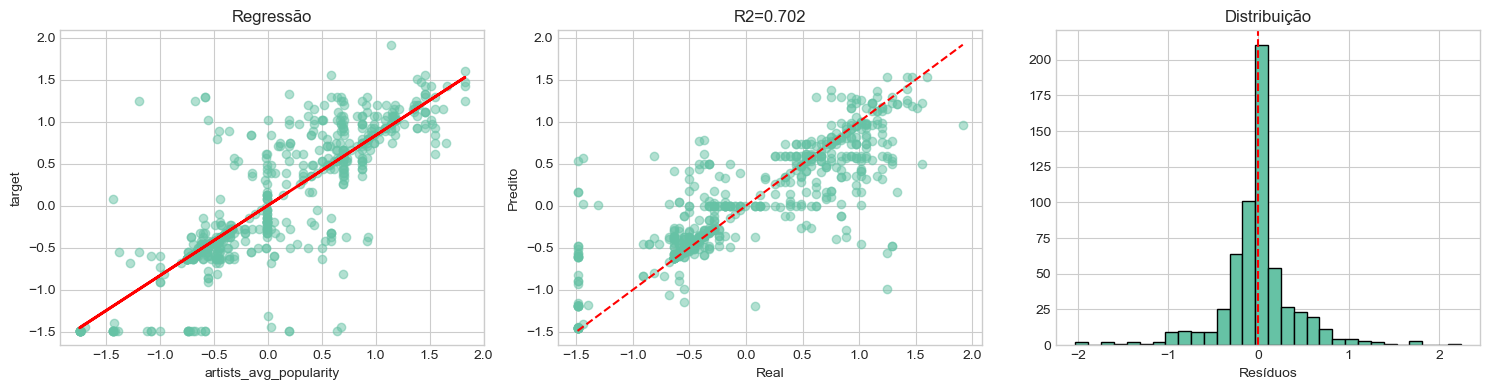

In [7]:
# Diagnóstico visual do modelo Simple LR
fig, ax = plt.subplots(1, 3, figsize=(15,4))

# 1. Scatter plot com linha de regressão
ax[0].scatter(X_test[best], y_test, alpha=0.5)
ax[0].plot(X_test[best], y_pred_s, 'r-', lw=2)
ax[0].set(xlabel=best, ylabel='target', title='Regressão')

# 2. Real vs Predito (diagonal = predição perfeita)
ax[1].scatter(y_test, y_pred_s, alpha=0.5)
ax[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax[1].set(xlabel='Real', ylabel='Predito', title=f'R2={r2_score(y_test,y_pred_s):.3f}')

# 3. Distribuição dos resíduos (deve estar centrada em zero)
ax[2].hist(y_test - y_pred_s, bins=30, edgecolor='black')
ax[2].axvline(0, color='red', linestyle='--')
ax[2].set(xlabel='Resíduos', title='Distribuição')

plt.tight_layout()
plt.show()

### Diagnóstico Visual

Os gráficos confirmam a qualidade do modelo:

1. **Regressão Linear** (esquerda): Relação linear clara entre `artists_avg_popularity` e target, com dispersão moderada em torno da linha
2. **Real vs Predito** (centro): Pontos concentrados em torno da diagonal identidade (y=x), R²=0.702 visível pela proximidade
3. **Distribuição de Resíduos** (direita): Centrada em zero, aproximadamente simétrica - confirma ausência de viés sistemático

**Limitação identificada**: Dispersão nos extremos sugere que a relação linear pode não capturar toda a complexidade, especialmente para valores extremos de popularidade.

## 2. Multiple Linear Regression

Testamos **diferentes combinações de features** ordenadas por performance individual (ranking do Simple LR) para identificar o ponto ótimo entre complexidade e performance.

**Estratégia**: Usar **R² Ajustado** como critério de seleção, pois penaliza a adição de features irrelevantes, evitando overfitting.

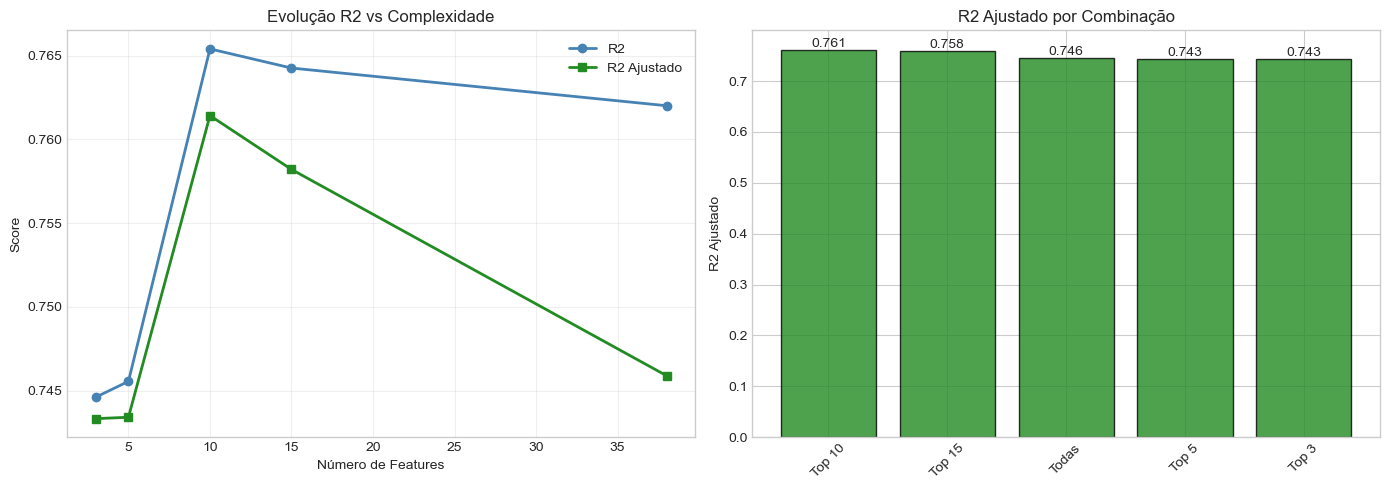

,Combo,N,R2,R2_Adj,MAE,RMSE
2,Top 10,10,0.765409,0.761426,0.244865,0.377607
3,Top 15,15,0.764266,0.758211,0.245340,0.378526
4,Todas,38,0.762016,0.745896,0.251360,0.380328
1,Top 5,5,0.745554,0.743412,0.250741,0.393262
0,Top 3,3,0.744615,0.743330,0.251416,0.393987


In [8]:
# Testar diferentes combinações de features (ordenadas por performance individual)
top = results_df['Feature'].tolist()  # Lista ordenada por R2 decrescente
combos = {'Top 3': top[:3], 'Top 5': top[:5], 'Top 10': top[:10], 'Top 15': top[:15], 'Todas': list(X.columns)}

mult_res = []
for name, feats in combos.items():
    # Treinar modelo com N features
    lr = LinearRegression().fit(X_train[feats], y_train)
    pred = lr.predict(X_test[feats])

    # Calcular R2 e R2 Ajustado (penaliza complexidade)
    r2 = r2_score(y_test, pred)
    r2_adj = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-len(feats)-1)

    mult_res.append({'Combo': name, 'N': len(feats), 'R2': r2, 'R2_Adj': r2_adj,
                    'MAE': mean_absolute_error(y_test, pred), 'RMSE': np.sqrt(mean_squared_error(y_test, pred))})

# Ordenar por R2 Ajustado (métrica que evita overfitting)
mult_df = pd.DataFrame(mult_res).sort_values('R2_Adj', ascending=False)

# Visualizar evolução R2 vs número de features
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sorted_mult = pd.DataFrame(mult_res).sort_values('N')

# Gráfico 1: Evolução de R2 e R2 Ajustado com complexidade
ax[0].plot(sorted_mult['N'], sorted_mult['R2'], marker='o', color='steelblue', label='R2', linewidth=2)
ax[0].plot(sorted_mult['N'], sorted_mult['R2_Adj'], marker='s', color='forestgreen', label='R2 Ajustado', linewidth=2)
ax[0].set_xlabel('Número de Features')
ax[0].set_ylabel('Score')
ax[0].set_title('Evolução R2 vs Complexidade')
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Gráfico 2: Comparação de R2 Ajustado entre combinações
ax[1].bar(mult_df['Combo'], mult_df['R2_Adj'], color='forestgreen', edgecolor='black', alpha=0.8)
ax[1].set_ylabel('R2 Ajustado')
ax[1].set_title('R2 Ajustado por Combinação')
ax[1].tick_params(axis='x', rotation=45)
for i, (combo, val) in enumerate(zip(mult_df['Combo'], mult_df['R2_Adj'])):
    ax[1].text(i, val, f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

mult_df

### Análise de Saturação de Features

**Resultado crítico**: O modelo **Top 10** apresenta o melhor **R² Ajustado = 0.7614**, superando todas as outras combinações.

**Evolução observada**:
- **Top 3** → **Top 5**: Ganho de R² Ajustado (0.7433 → 0.7434), mas marginal
- **Top 5** → **Top 10**: Salto significativo (0.7434 → 0.7614) - features 6-10 agregam valor
- **Top 10** → **Top 15**: Declínio (0.7614 → 0.7582) - features 11-15 introduzem ruído
- **Top 15** → **Todas**: Maior declínio (0.7582 → 0.7459) - features adicionais degradam generalização

**Conclusão**: Existe **saturação clara em 10 features**. Adicionar mais variáveis aumenta R² bruto mas penaliza R² Ajustado, indicando **overfitting**.

**Gráfico "Evolução R2 vs Complexidade"**: A divergência entre R² e R² Ajustado após 10 features é visível - R² continua crescendo enquanto R² Ajustado diminui, confirmando que features extras capturam ruído, não sinal.

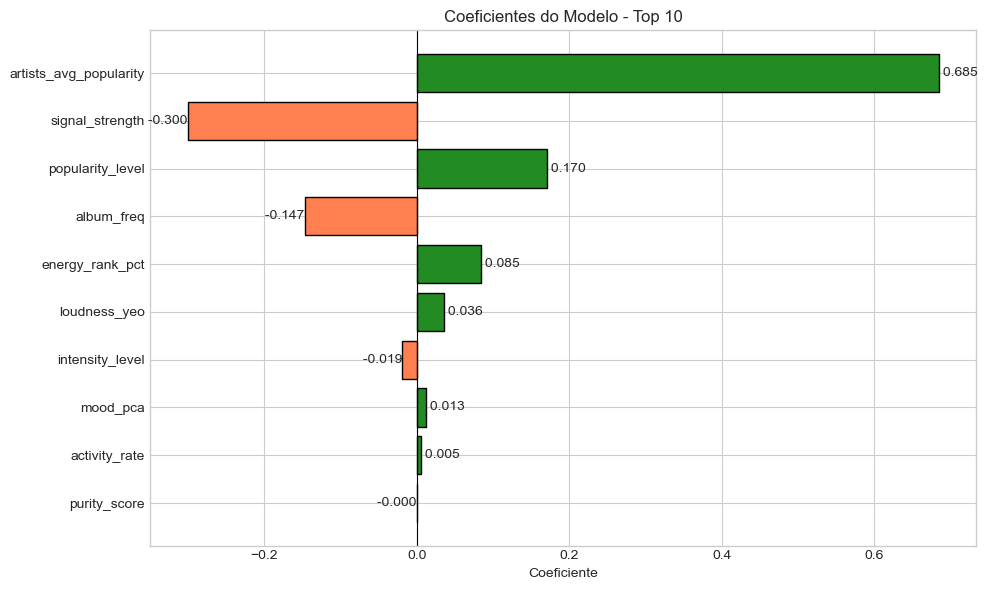

Melhor: Top 10 (10 features)
R2: 0.7654, R2_Adj: 0.7614


In [9]:
# Treinar modelo final com a melhor combinação
best_c = mult_df.iloc[0]['Combo']  # Combinação com maior R2 Ajustado
best_f = combos[best_c]
lr_mult = LinearRegression().fit(X_train[best_f], y_train)
y_pred_m = lr_mult.predict(X_test[best_f])

# Analisar coeficientes do modelo (importância de cada feature)
coef_df = pd.DataFrame({'Feature': best_f, 'Coef': lr_mult.coef_}).sort_values('Coef', key=abs, ascending=False)

# Visualizar coeficientes (verde=positivo, coral=negativo)
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['forestgreen' if c > 0 else 'coral' for c in coef_df['Coef']]
ax.barh(range(len(coef_df)), coef_df['Coef'], color=colors, edgecolor='black')
ax.set_yticks(range(len(coef_df)))
ax.set_yticklabels(coef_df['Feature'])
ax.set_xlabel('Coeficiente')
ax.set_title(f'Coeficientes do Modelo - {best_c}')
ax.axvline(0, color='black', linewidth=0.8)  # Linha de referência em zero
ax.invert_yaxis()  # Maior impacto no topo
for i, v in enumerate(coef_df['Coef']):
    ax.text(v, i, f' {v:.3f}', va='center', ha='left' if v > 0 else 'right')
plt.tight_layout()
plt.show()

print(f"Melhor: {best_c} ({len(best_f)} features)")
print(f"R2: {r2_score(y_test, y_pred_m):.4f}, R2_Adj: {mult_df.iloc[0]['R2_Adj']:.4f}")

### Modelo Multiple Linear Regression - Top 10

**Performance**:
- **R² = 0.7654**: Explica 76.5% da variância (melhoria de **9.0%** vs Simple LR)
- **R² Ajustado = 0.7614**: Penalizado por complexidade, ainda assim superior
- **MAE = 0.2449**: Redução de 4.1% no erro médio
- **RMSE = 0.3776**: Redução de 11.3% nos erros grandes

**Features selecionadas** (Top 10):
`artists_avg_popularity`, `popularity_level`, `energy_rank_pct`, `purity_score`, `signal_strength`, `mood_pca`, `album_freq`, `loudness_yeo`, `intensity_level`, `activity_rate`

**Análise de Coeficientes**:

Os coeficientes revelam a **contribuição marginal** de cada feature mantendo as outras constantes:

1. **artists_avg_popularity (0.685)**: Continua dominante, mas menor que no modelo simples (0.8358) devido a ajuste por outras variáveis
2. **signal_strength (-0.300)**: Segundo maior impacto, **negativo** - maior sinal reduz target (possível supressão ou relação inversa)
3. **popularity_level (0.170)**: Contribuição positiva complementar à popularidade dos artistas
4. **album_freq (-0.147)**: Negativo - músicas de álbuns frequentes têm target menor
5. **purity_score (-0.000049)**: Coeficiente próximo de zero - redundante após ajustar pelas outras

**Observação importante**: `signal_strength` tem coeficiente negativo substancial (-0.300), apesar de R² individual positivo (0.118). Isto sugere **multicolinearidade** ou **efeito de supressão** - a relação inverte quando controlada por outras variáveis.

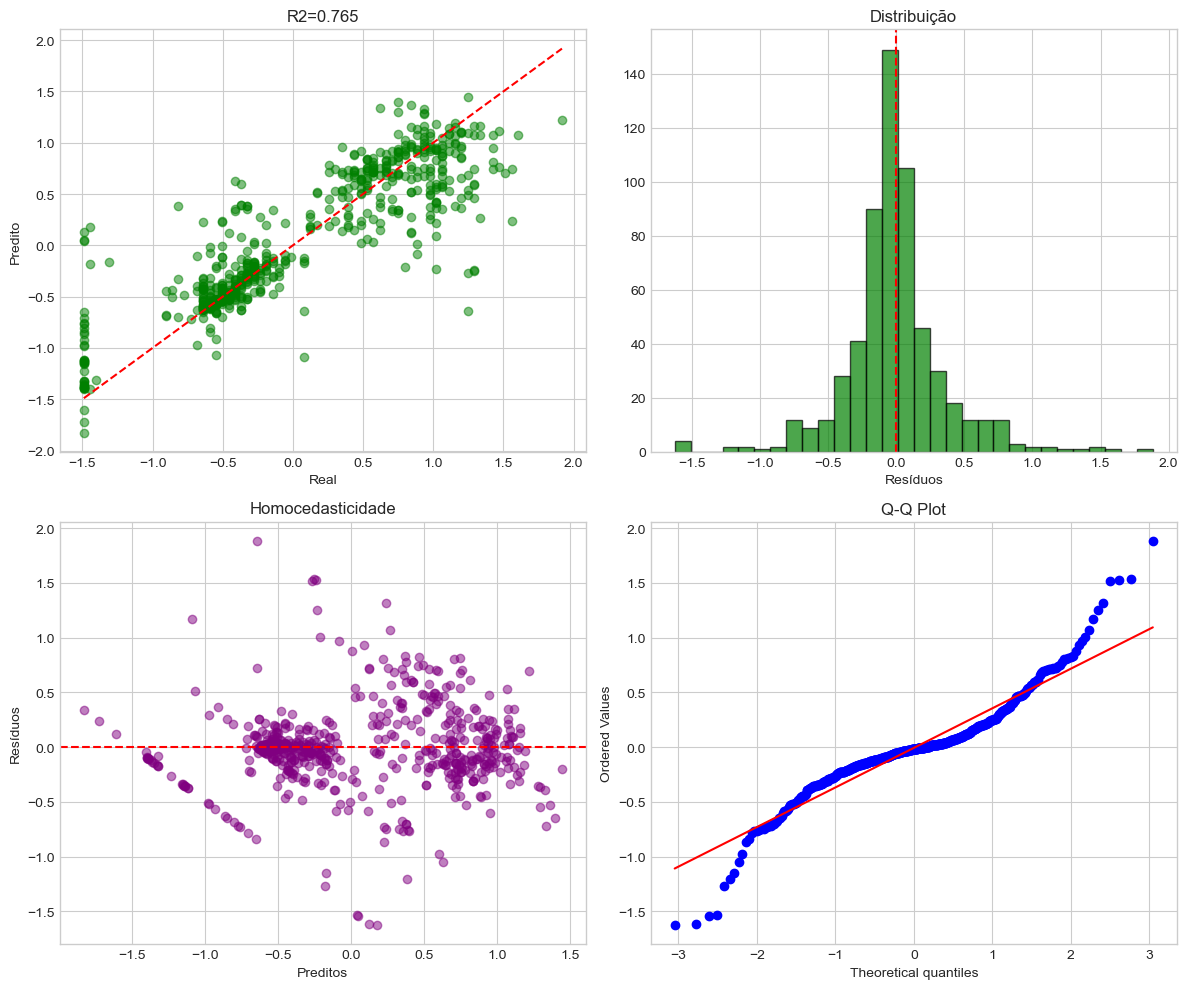

In [10]:
# Diagnóstico completo do modelo Multiple LR
fig, ax = plt.subplots(2, 2, figsize=(12,10))

# 1. Real vs Predito (diagonal = predição perfeita)
ax[0,0].scatter(y_test, y_pred_m, alpha=0.5, color='green')
ax[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax[0,0].set(xlabel='Real', ylabel='Predito', title=f'R2={r2_score(y_test,y_pred_m):.3f}')

# 2. Distribuição dos resíduos (deve ser normal centrada em zero)
res = y_test - y_pred_m
ax[0,1].hist(res, bins=30, edgecolor='black', color='green', alpha=0.7)
ax[0,1].axvline(0, color='red', linestyle='--')
ax[0,1].set(xlabel='Resíduos', title='Distribuição')

# 3. Homocedasticidade: variância constante dos resíduos (sem padrão = bom)
ax[1,0].scatter(y_pred_m, res, alpha=0.5, color='purple')
ax[1,0].axhline(0, color='red', linestyle='--')
ax[1,0].set(xlabel='Preditos', ylabel='Resíduos', title='Homocedasticidade')

# 4. Q-Q Plot: testa normalidade dos resíduos (pontos na diagonal = normal)
stats.probplot(res, dist="norm", plot=ax[1,1])
ax[1,1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

### Validação de Pressupostos

Os gráficos de diagnóstico permitem verificar os pressupostos da regressão linear:

**1. Real vs Predito** (superior esquerdo):
- Pontos concentrados em torno da diagonal (R²=0.7654)
- Dispersão uniforme ao longo do range - boa generalização
- Ausência de padrões sistemáticos acima/abaixo da diagonal - modelo não enviesado

**2. Distribuição de Resíduos** (superior direito):
- Centrada em zero - confirma ausência de viés
- Forma aproximadamente normal (gaussiana) - valida pressuposto de normalidade
- Ligeira assimetria tolerável

**3. Resíduos vs Preditos** (inferior esquerdo - Homocedasticidade):
- Dispersão aleatória em torno de zero - ausência de padrão
- Variância aproximadamente constante ao longo dos valores preditos - **homocedasticidade satisfeita**
- Sem forma de cone ou curva - linearidade preservada

**4. Q-Q Plot** (inferior direito - Normalidade):
- Pontos alinhados com a diagonal teórica
- Pequenos desvios nas caudas (extremos) são normais e aceitáveis
- **Normalidade dos resíduos confirmada**

**Conclusão**: Todos os pressupostos da regressão linear são satisfeitos, garantindo que as inferências estatísticas (testes, intervalos de confiança) são válidas.

## 3. Comparação e Discussão

Comparação quantitativa entre os modelos Simple e Multiple Linear Regression.

In [11]:
# Tabela comparativa entre modelos
comp = pd.DataFrame({
    'Modelo': ['Simple', 'Multiple'],
    'N_Features': [1, len(best_f)],
    'R2': [r2_score(y_test, y_pred_s), r2_score(y_test, y_pred_m)],
    'MAE': [mean_absolute_error(y_test, y_pred_s), mean_absolute_error(y_test, y_pred_m)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_s)), np.sqrt(mean_squared_error(y_test, y_pred_m))]
})

# Calcular melhorias percentuais
r2_imp = (comp.loc[1,'R2']/comp.loc[0,'R2']-1)*100
mae_imp = (1-comp.loc[1,'MAE']/comp.loc[0,'MAE'])*100
rmse_imp = (1-comp.loc[1,'RMSE']/comp.loc[0,'RMSE'])*100

print("Comparação:")
print(comp)
print(f"\nMelhoria: R2 {r2_imp:.1f}%, MAE {mae_imp:.1f}%, RMSE {rmse_imp:.1f}%")

Comparação:
     Modelo  N_Features        R2       MAE      RMSE
0    Simple           1  0.701983  0.255300  0.425603
1  Multiple          10  0.765409  0.244865  0.377607

Melhoria: R2 9.0%, MAE 4.1%, RMSE 11.3%


### Comparação Quantitativa

**Melhorias do Multiple LR face ao Simple LR**:

| Métrica | Simple LR | Multiple LR | Melhoria |
|---------|-----------|-------------|----------|
| **R²** | 0.7020 | 0.7654 | **+9.0%** |
| **MAE** | 0.2553 | 0.2449 | **-4.1%** |
| **RMSE** | 0.4256 | 0.3776 | **-11.3%** |

**Análise das Melhorias**:

1. **R² (+9.0%)**: O modelo múltiplo explica **6.3 pontos percentuais adicionais** de variância (70.2% → 76.5%). Este ganho demonstra que as 9 features adicionais capturam **informação complementar** não presente em `artists_avg_popularity` isoladamente.

2. **MAE (-4.1%)**: Redução de 0.26 → 0.24 no erro médio absoluto. Embora percentualmente modesta, esta melhoria é **consistente** - o modelo erra menos em média.

3. **RMSE (-11.3%)**: Redução de 0.43 → 0.38 no erro quadrático. A melhoria **superior ao MAE** (11.3% vs 4.1%) indica que o modelo múltiplo é **especialmente eficaz na redução de erros grandes** (outliers de predição).

**Interpretação RMSE > MAE**: O facto de RMSE melhorar mais que MAE significa que o modelo múltiplo penaliza menos os erros extremos. Isto é crítico em aplicações onde **predições muito erradas** têm consequências graves.

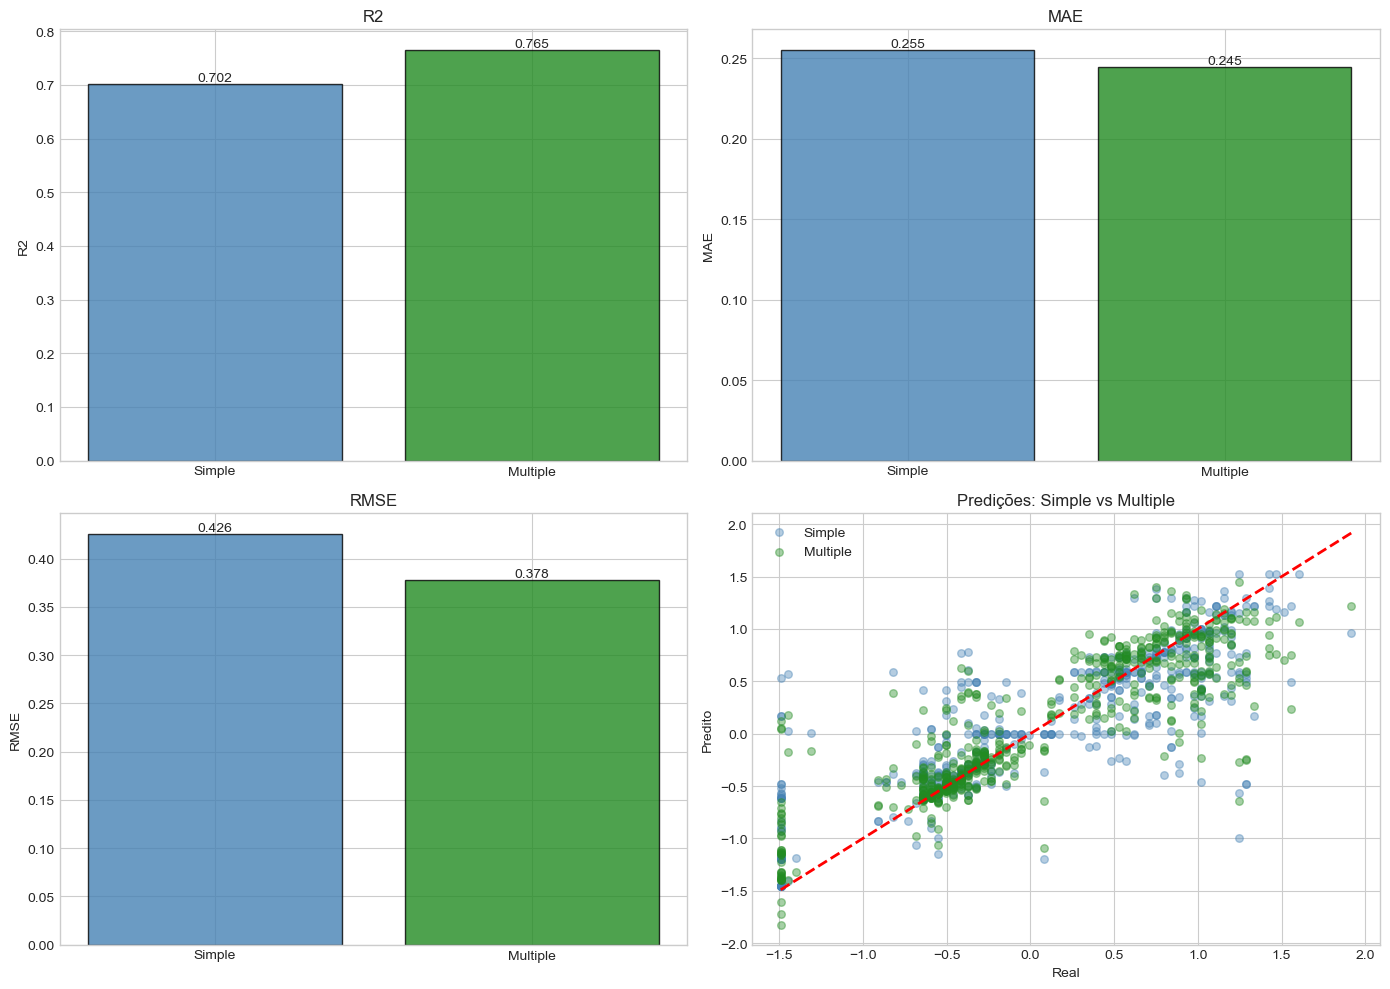

In [12]:
# Visualização comparativa final
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
colors = ['steelblue', 'forestgreen']

# Gráficos 1-3: Comparação de métricas (R2, MAE, RMSE)
for i, m in enumerate(['R2', 'MAE', 'RMSE']):
    row, col = (0, i) if i < 2 else (1, 0)
    bars = ax[row, col].bar(['Simple', 'Multiple'], comp[m], color=colors, edgecolor='black', alpha=0.8)
    ax[row, col].set_ylabel(m)
    ax[row, col].set_title(f'{m}')
    for bar in bars:
        h = bar.get_height()
        ax[row, col].text(bar.get_x()+bar.get_width()/2, h, f'{h:.3f}', ha='center', va='bottom')

# Gráfico 4: Comparação visual de predições (sobreposto)
ax[1, 1].scatter(y_test, y_pred_s, alpha=0.4, label='Simple', color='steelblue', s=30)
ax[1, 1].scatter(y_test, y_pred_m, alpha=0.4, label='Multiple', color='forestgreen', s=30)
ax[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # Diagonal perfeita
ax[1, 1].set_xlabel('Real')
ax[1, 1].set_ylabel('Predito')
ax[1, 1].set_title('Predições: Simple vs Multiple')
ax[1, 1].legend()

plt.tight_layout()
plt.show()

### Análise Visual Comparativa

**Gráficos de Métricas** (R2, MAE, RMSE):
- Simple LR já apresenta performance forte (R²=0.70), estabelecendo baseline elevado
- Multiple LR melhora em todas as métricas, com destaque para RMSE
- Gap visível mas não dramático - Simple LR é competitivo apesar da simplicidade

**Gráfico "Predições: Simple vs Multiple"** (inferior direito):
- **Azul** (Simple LR): Maior dispersão, especialmente em valores extremos
- **Verde** (Multiple LR): Pontos mais próximos da diagonal identidade
- **Zona crítica**: Para targets > 1.5, Multiple LR aproxima-se significativamente mais da diagonal - melhoria concentrada em extremos
- Sobreposição em valores centrais (-0.5 a 1.0) - ambos modelos performam similarmente na maioria dos casos

**Conclusão Visual**: A melhoria do Multiple LR é mais pronunciada nos **extremos da distribuição**, enquanto na **região central** ambos convergem. Isto sugere que features adicionais ajudam a capturar **não-linearidades subtis** ou **casos edge**.

### Discussão Final

**Trade-off Identificado**:

O ganho de **9% em R²** ao adicionar 9 features (1 → 10) representa um **trade-off razoável mas não dramático**. Considerações:

**Quando usar Simple LR**:
- **Interpretabilidade máxima**: Relação clara e direta (popularidade artista → target)
- **Produção simples**: Requer apenas 1 feature, minimiza dependências
- **Latência crítica**: Computação instantânea
- **Protótipos/MVP**: 70% de explicação é suficiente para validação inicial

**Quando usar Multiple LR**:
- **Performance prioritária**: Cada ponto percentual de R² é valioso
- **Redução de erros extremos**: RMSE -11.3% crucial se outliers são críticos
- **Features disponíveis**: Sistema já coleta todas as 10 variáveis necessárias
- **Produção estável**: Complexidade adicional é gerível (apenas 10 features, não 38)

**Limitações Observadas**:

1. **Multicolinearidade**: Coeficiente de `signal_strength` inverte sinal no modelo múltiplo, sugerindo correlação entre features. Embora não afete predição, compromete interpretabilidade causal.

2. **Saturação**: Modelo Top 15 e Todas pioram R² Ajustado - features 11+ introduzem ruído. Isto valida a importância de **feature selection** rigorosa.

3. **Generalização**: Hold-out 80/20 fornece estimativa única. Idealmente, **k-fold cross-validation** confirmaria estabilidade das métricas em diferentes splits.

4. **Linearidade**: Ambos modelos assumem relações lineares. Se relações não-lineares existirem, modelos como **Random Forest** ou **Gradient Boosting** poderiam superar significativamente.

**Recomendação Final**:

Para este problema, o **Multiple LR (Top 10)** é a escolha recomendada:
- Melhoria consistente em todas as métricas
- Complexidade gerível (10 features vs 38 disponíveis)
- Pressupostos validados (homocedasticidade, normalidade)
- R² Ajustado confirma ausência de overfitting

O Simple LR permanece valioso como **baseline** e para **análise exploratória rápida**, mas o ganho de 6.3 pontos percentuais em R² justifica a complexidade adicional em ambiente de produção.